$\def \dot #1#2{\left\langle #1, #2 \right\rangle}$
$\def \adot #1#2{\left\langle #1, #2 \right\rangle}$
$\def \cA {\mathcal{A}}$
$\def \cD {\mathcal{D}}$
$\def \cM {\mathcal{M}}$
$\def \cN {\mathcal{N}}$
$\def \cW {\mathcal{W}}$
$\def \bc {\mathbf{c}}$
$\def \bu {\mathbf{u}}$
$\def \bv {\mathbf{v}}$
$\def \bw {\mathbf{w}}$
$\def \bG {\mathbf{G}}$
$\def \bC {\mathbf{C}}$
$\def \bD {\mathbf{D}}$
$\def \bI {\mathbf{I}}$
$\def \bR {\mathbf{R}}$
$\def \bS {\mathbf{S}}$
$\def \bT {\mathbf{T}}$
$\def \bU {\mathbf{U}}$
$\def \bV {\mathbf{V}}$
$\def \bW {\mathbf{W}}$
$\def \bPhi {\mathbf{\Phi}}$
$\def \bPsi {\mathbf{\Psi}}$
$\def \bGamma {\mathbf{\Gamma}}$
$\def \bSigma {\mathbf{\Sigma}}$
$\def \bTheta {\mathbf{\Theta}}$
$\def \bOmega {\mathbf{\Omega}}$
$\def \bbE {\mathbb{E}}$
$\def \bbP {\mathbb{P}}$
$\def \bbR {\mathbb{R}}$
$\def \bbN {\mathbb{N}}$

# What is the optimal PCA reconstruction point when $n < N < K$?

Lets consider the ambient space $\bbR^K$, for some very large $K$ that we'll likely never attain in our number of samples $N$, and in any case we consider the case where $\cM$ is embedded in a space of dimension no more than $n$. This presents potentially a better setting to calculate our optimal reconstruction, but we lose a bunch of the results used in the document so far. I attempt to re-calculate some of these quantities or demonstrate best analogues.

First we'll generate a collection of $N$ points in an $M$ dimensional space.

In [1]:
import numpy as np
import scipy as sp
import importlib
import seaborn as sns
import matplotlib.pyplot as plt
import pdb

import sys
sys.path.append("../../")
import pyApproxTools as pat
importlib.reload(pat)

%matplotlib inline

In [2]:
K = 100  # The dimensionality of the ambient space (can be up to 2^16 for FEM solutions)
n = 4    # The truncation dimension of the PCA / embedding dimension of the manifold 
N = 20   # Number of dictionary samples (NB Note used yet, only for "empirical" results)
m = 6    # The dimension off the measurement space

np.random.seed(1)

# First make two random orthonormal vector bases
Phi = sp.stats.ortho_group.rvs(dim=K) # The "PCA" space
Psi = sp.stats.ortho_group.rvs(dim=K) # The "measurement" space

sigma = np.sort(np.random.random(K))[::-1]
#sigma[n:] = 0
D = np.diag(sigma**2)
D_inv = np.diag(1.0 / sigma**2)
Sigma = np.diag(sigma[:n])
Sigma_inv = np.diag(1.0 / sigma[:n])

# This is the original covariance matrix!
u0 = np.random.random(K) / np.sqrt(K) # u_0 is the notional center
V = Phi[:,:n]
C = V @ Sigma @ Sigma @ V.T
points = np.random.multivariate_normal(u0, C, N)

u0_e = points.mean(axis=0) # Empirical mean...
U = (points - u0_e).T
print('K={0}, n={1}, N={2}, U is dim {3}'.format(K,n,N,U.shape))

W = Psi[:,:m]
CG = W.T @ Phi[:,:n]
betas = sp.linalg.svd(CG, compute_uv=False)

print('Wm is of dimension {0} and beta(W, Phi) is {1}'.format(m, betas[-1] ))

K=100, n=4, N=20, U is dim (100, 20)
Wm is of dimension 6 and beta(W, Phi) is 0.09902624038430155


In [3]:
G_e = U.T @ U
C_e = U @ U.T

print('C_e is of shape {0} but only of rank {1}'.format(C_e.shape, np.linalg.matrix_rank(C_e)))
print('G_e is of shape {0} but only of rank {1}'.format(G_e.shape, np.linalg.matrix_rank(G_e)))

C_e is of shape (100, 100) but only of rank 4
G_e is of shape (20, 20) but only of rank 4


Note in the above code we write ```C_e``` to mean "empirical" $\bC$.

Now we test the two ways to calculate the best "estimator" for some $u$ and corresponding measurement $u$. __Let us forget the complications of the "empirical" vs "true" PCA for now__, and just use the two orthonormal bases $\bPhi = [\varphi_1,\ldots,\varphi_K]$, with associated $\sigma_1,\ldots,\sigma_K$, and $\bPsi = [\psi_1,\ldots,\psi_K]$ for which $\bW = [\psi_1,\ldots,\psi_m]$ is the measurement basis, obviously $\bW_\perp = [\psi_{m+1},\ldots,\psi_K]$.

First we generate a point $u$ that is not too far from $u_0$, and in the span of $[\varphi_1,\ldots,\varphi_n]$, and take its measurement in $\bW$, given here by $P_W u = \bW \bW^T u$

In [5]:
np.random.seed(2)

pert = (1e-2 * np.random.random(n) / np.sqrt(n) * sigma[:n])

u = u0 + Phi[:,:n] @ pert
w = W @ W.T @ u

print('|| u ||       =', np.linalg.norm(u))
print('|| u_0 ||     =', np.linalg.norm(u0))
print('|| u - u_0 || =', np.linalg.norm(u - u0))
print('|| w ||       =', np.linalg.norm(w))
print('|| u - w ||   =', np.linalg.norm(u - w))

|| u ||       = 0.6151958492557501
|| u_0 ||     = 0.6151351606403517
|| u - u_0 || = 0.003907277301185513
|| w ||       = 0.17874357801488
|| u - w ||   = 0.5886566624611856


Albert's scheme is the following:

$$
\bw_\perp^* = -\bT_{2,2}^{-1} \bT_{2,1} \bw
$$

where $\bw_\perp^*\in\bbR^{K-m}$ and $\bw\in\bbR^m$, i.e. they are the representation in the $\psi_i$ basis.

where $\bT = \bG^T \bD^{-1} \bG = (\bPhi^T \bPsi)^T \bD^{-1} (\bPhi^T \bPsi)$, the diagonal matrix $\bD = \mathrm{diag}(\sigma_1^2,\ldots,\sigma_n^2)$, and (2,2) subscript refers to the first $m$ or second $m$ block.

Note also that, using the above notation $\bPsi = \begin{bmatrix} \bW & \bW_\perp \end{bmatrix}$, so in fact

$$
\bG = \bPhi^T \bPsi = \begin{bmatrix} \bPhi^T\bW & \bPhi^T\bW_\perp \end{bmatrix}
$$

Writing $\bSigma_K = \mathrm{diag}(\sigma_1^2,\ldots,\sigma_K^2)$, i.e. not truncated at $n$, we see that we get

$$
\bT = 
\begin{bmatrix}
\bW^T\bPhi \\
\bW_\perp^T\bPhi
\end{bmatrix}
\begin{bmatrix}\bSigma_K^{-1} \end{bmatrix}
\begin{bmatrix} \bPhi^T \bW & \bPhi^T \bW_\perp \end{bmatrix}
=
\begin{bmatrix}
\bW^T \bPhi \bSigma_K^{-1} \bPhi^T \bW & \bW^T \bPhi \bSigma_K^{-1} \bPhi^T \bW_\perp \\
\bW_\perp^T \bPhi \bSigma_K^{-1} \bPhi^T \bW & \bW_\perp^T \bPhi \bSigma_K^{-1} \bPhi^T \bW_\perp
\end{bmatrix}
$$

which give us the expressions for $\bT_{1,1}$, $\bT_{1,2}$ etc...

In fact, another way to approach this whole problem see it as the Schur complement problem. If $\bu \in \bbR^K$ is $u$ described in the $\psi_i$ basis, then the minimisation is looking at 

$$
\bu^* =
\mathrm{argmin}_{P_W \bu = \bw} \bu^T \bT \bu = \mathrm{argmin}_{\bw_\perp^*} 
\begin{bmatrix} \bw \\ \bw_\perp \end{bmatrix}^T  
\begin{bmatrix}
\bT_{1,1} & \bT_{1,2} \\
\bT_{2,1} & \bT_{2,2} 
\end{bmatrix}
\begin{bmatrix} \bw \\ \bw_\perp \end{bmatrix}
$$
which can eventually be found 
$$
\bw_\perp^* =
\mathrm{argmin}_{\bw_\perp} 
\left( \bw^T \bT_{1,1} \bw^T + 2 \bw_\perp^T \bT_{2,1} \bw + \bw_\perp^T \bT_{2,2} \bw_\perp \right)
$$

Just the old quadratic form in terms of $\bw_\perp$, and the minimiser is $\bT_{2,1} \bw + \bT_{2,2} \bw_\perp^* = 0$ and we get the solution above.

In [6]:
G = (Phi.T @ Psi)
T = G.T @ D_inv @ G

T21 = T[m:, :m]
T22 = T[m:, m:]

#T21 = Psi[:,m:].T @ V @ np.diag(1.0/sigma[:n]**2) @ V.T @ Psi[:,:m]
#T22 = Psi[:,m:].T @ V @ np.diag(1.0/sigma[:n]**2) @ V.T @ Psi[:,m:]
print('rank:', np.linalg.matrix_rank(T22), T22.shape)
# Just to check
print('|| T_21 - Psi[:,m:].T @ Phi @ D_inv @ Phi.T @ Psi[:,:m] ||_F \
= {0} (Frobenius norm)'.format(np.linalg.norm(T21 - Psi[:,m:].T @ Phi @ D_inv @ Phi.T @ Psi[:,:m] )))

print('\nCondition numbers: \nkappa(T_22) = {0}\nkappa(T_21) = {1}\n'.format(np.linalg.cond(T22), np.linalg.cond(T21)))

#w_perp_star = - np.linalg.solve(T22, T21 @ W.T @ w)
w_perp_star = - np.linalg.pinv(T22) @ T21 @ W.T @ w

u_star_albert = w + Psi[:,m:] @ w_perp_star

print('|| u - u* ||       =', np.linalg.norm(u - u_star_albert))
print('|| u_0 - u* ||     =', np.linalg.norm(u0 - u_star_albert))
print('|| w - u* ||       =', np.linalg.norm(w - u_star_albert))


rank: 94 (94, 94)
|| T_21 - Psi[:,m:].T @ Phi @ D_inv @ Phi.T @ Psi[:,:m] ||_F = 1.2267966862714528e-11 (Frobenius norm)

Condition numbers: 
kappa(T_22) = 78211.85097357862
kappa(T_21) = 265.7405087857801

|| u - u* ||       = 0.588993579389868
|| u_0 - u* ||     = 0.588915257111193
|| w - u* ||       = 0.1257189368383046


### Lets test a few aspects of this

 - Do we have that $\cA(u^*) = u^*$

In [7]:
w_u_star = W @ W.T @ u_star_albert
w_perp_star_star = - np.linalg.solve(T22, T21 @ W.T @ w_u_star)
u_star_star = w + Psi[:,m:] @ w_perp_star_star
print('|| u* - u** ||       =', np.linalg.norm(u_star_star - u_star_albert))

#u_star_coords = (Phi.T @ (u_star_albert - u0))
#print(u_star_coords)
#print(sigma)

|| u* - u** ||       = 4.4576075707668593e-13


### Stop press, try Lagrange multipliers

We wan't to minimise $\tilde u^T \tilde u$ given that $\bW^T \bV \bSigma \tilde u = \bW^T w$

### Another scheme is to fix $W_\perp$ within $V$

How does this work? My rationalle is that $u^*$ is a unique minimiser of the intersection of $W_\perp + w$ and $u_0 + V_n$. _Surely_ we can express this just in terms of $V_n$?

So - given $u \in \bbR^K$, when is expressed in the $\varphi_i$ coordinates, we have that

$$u = \bV u_V$$

and $\bW^T \bV u_V = \bW^T w$, obv we have that $\bW^T \bV \in \bbR^{m \times n}$, so has rank at most $n$. Ah, this is where the lifting business is important - because we know that 

Now, a rank $K-m$ problem is
$$
\bW \bW^T u = w
$$

My logic is as follows: for any $\tilde u \in \bbR^n$ where $u\in V_n$ is expressed by $u = \bV \bSigma \tilde u$ we are doing the minimisation with the following quantity fixed.

$$
w = \bW \bW^T \bV \bSigma \tilde u
$$

Also note that 

$$
\bW \bW^T + \bW_\perp \bW_\perp^T = \bPhi \bPhi^T = I
$$

So 

$$
\begin{aligned}
u 
&= w + w_\perp \\
&= \bW \bW^T \bV \bSigma \tilde u + \bW_\perp \bW_\perp^T \bV \bSigma \tilde u \\
&= (\bW \bW^T \bV+ (I - \bW \bW^T) ) \bV \bSigma \tilde u \\
&= w + (I - \bW \bW^T) \bV \bSigma \tilde u \\
\end{aligned}
$$

We can write $u$ as 

So we want to minimise $\tilde u^t \tilde u$ such that $\bW \bW^T u = \bW \bW^T \bV \bSigma \tilde u = w$, well then we want to minimise

$$
\begin{aligned}
\left( \bSigma^{-1} \bV^T (w + w_\perp) \right)^T \left( \bSigma^{-1} \bV^T (w + w_\perp)\right) 
& = w^T \bV \bSigma^{-2} \bV^T w + 2 w^T \bV \bSigma^{-2} \bV^T w_\perp + w_\perp^T \bV \bSigma^{-2} \bV^T w_\perp \\
& = w^T \bV \bSigma^{-2} \bV^T w + 2 w^T \bV \bSigma^{-2} \bV^T (I - \bW \bW^T) \bV \bSigma \tilde u + \left( (I - \bW \bW^T) \bV \bSigma \tilde u \right)^T \bV \bSigma^{-2} \bV^T (I - \bW \bW^T) \bV \bSigma \tilde u \\
\end{aligned}
$$

Now we want to take the derivative in the direction of $\bSigma^{-1} \bV^T (I - \bW \bW^T) \bV \bSigma \tilde u$

In [317]:
G = W.T @ V @ Sigma
print(np.linalg.matrix_rank(G), G.shape)

uG, sG, vG = sp.linalg.svd(G)

Wfav = W @ uG.T
Vfav = V @ vG.T

#print(Wfav.shape, Vfav.shape)
#print(Wfav[:,:n] @ Wfav[:,:n].T @ (u-u0) - W @ W.T @ (u-u0))

# Ok - so Wfav up til vector n will definitely contain w, and further more be of the same dimensionality
lam_tilde = (1.0/(sG*sG)) * (Wfav[:,:n].T @ (u-u0))
lam_tilde_2 = (1.0/(sG*sG)) * (uG[:n] @ (W.T @ (u-u0)))

print(lam_tilde)

print(lam_tilde_2)

u_t_a = u_star_albert - Vfav @ Vfav.T @ (u_star_albert - u0)
print(u_t_a)

u_star_1 = Vfav @ lam_tilde_2
u_star_2 = V @ Sigma @ u_tilde

print('\n|| u*_a - u*_1 ||   =', np.linalg.norm(u_star_albert - u_star_1))
print('\n|| u*_a - u*_2 ||   =', np.linalg.norm(u_star_albert - u_star_2))
print('\n|| u*_1 - u*_2 ||   =', np.linalg.norm(u_star_1 - u_star_2))

4 (6, 4)
[-0.00270544  0.00576414  0.00821772 -0.02313032]
[-0.00270544  0.00576414  0.00821772 -0.02313032]
[-0.02466493  0.01824618  0.02793696 -0.00497143  0.0193807   0.01769877
 -0.02983778  0.02728139  0.03505706 -0.01270915  0.02442923 -0.01069332
  0.02690723  0.00376965  0.01954816  0.01289991 -0.00215582  0.02551497
 -0.0396289   0.01490916  0.00439514  0.01893165  0.01204279  0.01101446
  0.02982631  0.01635514 -0.00336866 -0.01909542  0.00465681  0.01459496
 -0.02171893  0.04871353 -0.03570855 -0.01749501 -0.03866849 -0.01598471
 -0.01264606  0.01050698 -0.01747766 -0.00996862 -0.00056229 -0.01564142
  0.01466246  0.03424158 -0.04256694  0.02240546  0.00686161  0.00305633
  0.01918888 -0.0053641   0.02021473 -0.00502451 -0.02997484  0.05562247
  0.00496557  0.02945244  0.00862564  0.01381963  0.01165388  0.01489417
  0.00496655  0.03752073  0.00286693 -0.01800639  0.04572924  0.017934
 -0.02111822  0.00049498  0.00954262  0.04176328 -0.00190204 -0.01054928
  0.00493412  0.0

In [324]:
Q = Psi.T @ Phi @ Sigma_K
print(np.linalg.matrix_rank(Q), Q.shape)

uQ, sQ, vQ = sp.linalg.svd(Q)

Psifav = Psi @ uQ.T
Phifav = Phi @ vQ.T

# Ok - so Wfav up til vector n will definitely contain w, and further more be of the same dimensionality
lam_tilde = (1.0/(sQ*sQ)) * (Psifav[:,:n].T @ (u-u0))
lam_tilde_2 = (1.0/(sQ*sQ)) * (uQ[:n] @ (Psi.T @ (u-u0)))

print(lam_tilde)

print(lam_tilde_2)

u_t_a = u_star_albert - Vfav @ Vfasv.T @ (u_star_albert - u0)
print(u_t_a)

u_star_1 = Vfav @ lam_tilde_2
u_star_2 = V @ Sigma @ u_tilde

print('\n|| u*_a - u*_1 ||   =', np.linalg.norm(u_star_albert - u_star_1))
print('\n|| u*_a - u*_2 ||   =', np.linalg.norm(u_star_albert - u_star_2))
print('\n|| u*_1 - u*_2 ||   =', np.linalg.norm(u_star_1 - u_star_2))

100 (100, 100)


ValueError: operands could not be broadcast together with shapes (100,) (4,) 

In [213]:
#print((W.T @ V @ Sigma).shape, Sigma.shape, V.shape, W.shape)
L = np.block([[np.eye(n), -Sigma @ V.T @ W], [W.T @ V @ Sigma, np.zeros((m,m))]])

print(np.linalg.matrix_rank(L), L.shape)

wL = np.block([np.zeros(n), W.T @ u])

wot = np.linalg.solve(L, wL)
wot2 = np.linalg.pinv(L) @ wL

Q = Sigma_inv @ V.T @ W @ W.T @ V @ Sigma
Q_perp = Sigma_inv @ V.T @ (np.eye(K) - W @ W.T) @ V @ Sigma

#print(sp.linalg.svd(W.T @ V @ Sigma))
print(sp.linalg.svd(Sigma_inv @ V.T @ (np.eye(K) - W @ W.T) @ V @ Sigma)[0])
print(sp.linalg.svd(Sigma_inv @ V.T @ (np.eye(K) - W @ W.T) @ V @ Sigma)[1])
print(sp.linalg.svd(Sigma_inv @ V.T @ (np.eye(K) - W @ W.T) @ V @ Sigma)[2])
print(sp.linalg.svd(Sigma_inv @ V.T @ (W @ W.T) @ V @ Sigma)[0])
print(sp.linalg.svd(Sigma_inv @ V.T @ (W @ W.T) @ V @ Sigma)[1])
print(sp.linalg.svd(Sigma_inv @ V.T @ (W @ W.T) @ V @ Sigma)[2])
#print(np.linalg.norm(V @ wot2[:n] + u0 - u_star_albert))

print(np.linalg.cond(Q), np.linalg.cond(Q_perp))

4 (6, 6)
[1.31420142e-01 4.04876648e-02 3.34379060e-02 8.77059406e-03
 1.47067581e-17 5.90966432e-18]
8 (10, 10)
[[-0.55346245  0.07233685 -0.47077718  0.68323901]
 [ 0.37343352  0.10942025  0.59652722  0.70194721]
 [-0.13476957 -0.97477915  0.14921115  0.09684423]
 [-0.73216384  0.18055526  0.63266117 -0.17628319]]
[0.99019436 0.9625923  0.95476322 0.85379097]
[[-0.55365442  0.3733379  -0.13478242 -0.73206509]
 [ 0.07237527  0.10945139 -0.9747739   0.18054931]
 [-0.47075496  0.59646167  0.14921713  0.63273809]
 [ 0.6830947   0.70204892  0.09686995 -0.17642325]]
[[-0.68234186  0.46998488  0.07260746  0.55520443]
 [-0.70257204 -0.59573491  0.10954409 -0.37348699]
 [-0.09695443 -0.14938953 -0.97474001  0.13477585]
 [ 0.17720596 -0.63395339  0.18058286  0.73081528]]
[0.14620933 0.04523695 0.03740772 0.00980608]
[[-0.68399169 -0.70142145 -0.09675932  0.17550201]
 [ 0.47154275 -0.59725804 -0.14903873 -0.63144099]
 [ 0.07210737  0.10932621 -0.9748124   0.18052448]
 [ 0.5519088  -0.37328081  

In [266]:


w_c = w - W @ W.T @ u0
w_c_w = W.T @ (u - u0)

Sigma_inv_K = np.diag(1.0/sigma)
Sigma_K = np.diag(sigma)
Q = Sigma_inv_K @ Phi.T @ W @ W.T @ Phi @ Sigma_K
Q_perp = Sigma_inv_K @ Phi.T @ (np.eye(K) - W @ W.T) @ Phi @ Sigma_K

#Q = np.diag(1.0/sigma[:n]) @ V.T @ W @ W.T @ V @ np.diag(sigma[:n])
#Q_perp = np.diag(1.0/sigma[:n]) @ V.T @ (np.eye(K) - W @ W.T) @ V @ np.diag(sigma[:n])

#Q = W @ W.T @ Phi @ Sigma_K
#Q_perp = (np.eye(K) - W @ W.T) @ Phi @ Sigma_K
#u_star_tilde_james = np.linalg.solve(Q_perp, w_c)
#u_star_james = V @ Sigma @ u_star_tilde_james

uQ,sQ,vQh = sp.linalg.svd(Q)
uQp,sQp,vQph = sp.linalg.svd(Q_perp)

W_perp_tilde_perp = vQph[sQp < 1e-12]
W_tilde = vQh[sQ > 1e-12] # We could also find W_tilde_perp = vQh[sQp < 1e-12]

# The solution *should* be unique in the span of W_perp_tilde_perp, which means
u_star_james = u0 + W_perp_tilde_perp.T @ np.linalg.solve(W.T @ W_perp_tilde_perp.T, W.T @ (u - u0))

# NOTE THAT THESE TWO ARE NOT ORTHOGONAL!!!
print('[W_tilde W_perp_tilde] rank {0}'.format(np.linalg.matrix_rank(np.vstack((W_tilde, W_perp_tilde)))))
print('[W_tilde] rank {0}'.format(np.linalg.matrix_rank(W_tilde)))
print('[W_perp_tilde] rank {0}'.format(np.linalg.matrix_rank(np.vstack(W_perp_tilde))))

print('Q is of shape {0} and rank {1}'.format(Q.shape, np.linalg.matrix_rank(Q)))
print('Q_perp is of shape {0} and rank {1}\n'.format(Q_perp.shape, np.linalg.matrix_rank(Q_perp)))

# Is Albert's answer in the span of W_perp_tilde?
#coeffs = W_perp_tilde @ (u_star_albert - u0)
#print(coeffs)
#print((u_star_albert-u0) - W_tilde.T @ coeffs)

# So my answer is *maybe* in the span of W_perp_tilde...

# What is going on here?

w_c = W.T @ (u_star_james-u0)
me = np.linalg.solve(W.T @ W_perp_tilde_perp.T, W.T @ (u_star_james - u0))
u_star_star = u0 + W_perp_tilde_perp.T @ me

#u_star_tilde_james = np.linalg.solve(Q_perp, Sigma_inv_K @ Phi.T @ w)
#u_star_james = Phi @ Sigma_K @ u_star_tilde_james

# Can test: explicitly construct Q_perp from W_perp, does indeed give us the same answer
#Q_perp_explicit = Sigma_inv @ V.T @ Psi[:,m:] @ Psi[:,m:].T @ V @ Sigma

print('|| u ||       =', np.linalg.norm(u))
print('|| u_0 ||     =', np.linalg.norm(u0))
print('|| u - u_0 || =', np.linalg.norm(u - u0))
print('|| w ||       =', np.linalg.norm(w))
print('|| u - w ||   =', np.linalg.norm(u - w))
print('')
print('|| u - u*j ||       =', np.linalg.norm(u - u_star_james))
print('|| u_0 - u*j ||     =', np.linalg.norm(u0 - u_star_james))
print('|| w - u*j ||       =', np.linalg.norm(w - u_star_james))
print('|| u*_j - u**_j ||  =', np.linalg.norm(u_star_james - u_star_star))
print('')
print('|| u - u*a ||       =', np.linalg.norm(u - u_star_albert))
print('|| u_0 - u*a ||     =', np.linalg.norm(u0 - u_star_albert))
print('|| w - u*a ||       =', np.linalg.norm(w - u_star_albert))

print('\n|| u*_a - u*_j ||   =', np.linalg.norm(u_star_albert - u_star_james))

print('\n||C u - u*j ||       =', (u-u_star_james).T @ Phi @ D @ Phi.T @ (u-u_star_james))
print('||C u - u*a ||       =', (u-u_star_albert).T @ Phi @ D @ Phi.T @ (u-u_star_albert))

[W_tilde W_perp_tilde] rank 12
[W_tilde] rank 6
[W_perp_tilde] rank 6
Q is of shape (100, 100) and rank 6
Q_perp is of shape (100, 100) and rank 94

|| u ||       = 0.6151958492557501
|| u_0 ||     = 0.6151351606403517
|| u - u_0 || = 0.003907277301185513
|| w ||       = 0.17874357801488
|| u - w ||   = 0.5886566624611856

|| u - u*j ||       = 0.012489005066512555
|| u_0 - u*j ||     = 0.011953059143353355
|| w - u*j ||       = 0.5906234073338432
|| u*_j - u**_j ||  = 4.065974981473035e-17

|| u - u*a ||       = 0.588993579389868
|| u_0 - u*a ||     = 0.5889152571111931
|| w - u*a ||       = 0.1257189368383046

|| u*_a - u*_j ||   = 0.5913580920764393

||C u - u*j ||       = 6.81501929565927e-05
||C u - u*a ||       = 0.12814025702631107


### Scratch
$$
\left( \bSigma^{-1} \bV (w + (I - \bW \bW^T) \bV \bSigma \tilde u) \right)^T \left( \bSigma^{-1} \bV (w + (I - \bW \bW^T) \bV \bSigma \tilde u) \right)
$$

$$
(w + (I - \bW \bW^T) \bV \bSigma \tilde u)^T (w + (I - \bW \bW^T) \bV \bSigma \tilde u)
= w^T w + 2 ((I - \bW \bW^T) \bV \bSigma \tilde u)^T w + ((I - \bW \bW^T) \bV \bSigma \tilde u)^T (I - \bW \bW^T) \bV \bSigma \tilde u
$$

worth thinking about:
 - A favorable basis between $W$ and $V$, maybe with $\Sigma$ included somehow, see if that yields simpler derivations


In [183]:
w_c = w - W @ W.T @ u0
w_c_w = W.T @ (u - u0)

Sigma_inv_K = np.diag(1.0/sigma)
Sigma_K = np.diag(sigma)
Q = Sigma_inv_K @ Phi.T @ W @ W.T @ Phi @ Sigma_K
Q_perp = Sigma_inv_K @ Phi.T @ (np.eye(K) - W @ W.T) @ Phi @ Sigma_K

#Q = np.diag(1.0/sigma[:n]) @ V.T @ W @ W.T @ V @ np.diag(sigma[:n])
#Q_perp = np.diag(1.0/sigma[:n]) @ V.T @ (np.eye(K) - W @ W.T) @ V @ np.diag(sigma[:n])

#Q = W @ W.T @ Phi @ Sigma_K
#Q_perp = (np.eye(K) - W @ W.T) @ Phi @ Sigma_K
#u_star_tilde_james = np.linalg.solve(Q_perp, w_c)
#u_star_james = V @ Sigma @ u_star_tilde_james

uQ,sQ,vQh = sp.linalg.svd(Q)
uQp,sQp,vQph = sp.linalg.svd(Q_perp)

W_perp_tilde_perp = vQph[sQp < 1e-12]
W_tilde = vQh[sQ > 1e-12] # We could also find W_tilde_perp = vQh[sQp < 1e-12]

# The solution *should* be unique in the span of W_perp_tilde_perp, which means
u_star_james = u0 + W_perp_tilde_perp.T @ np.linalg.solve(W.T @ W_perp_tilde_perp.T, W.T @ (u - u0))

# NOTE THAT THESE TWO ARE NOT ORTHOGONAL!!!
print('[W_tilde W_perp_tilde] rank {0}'.format(np.linalg.matrix_rank(np.vstack((W_tilde, W_perp_tilde)))))
print('[W_tilde] rank {0}'.format(np.linalg.matrix_rank(W_tilde)))
print('[W_perp_tilde] rank {0}'.format(np.linalg.matrix_rank(np.vstack(W_perp_tilde))))

print('Q is of shape {0} and rank {1}'.format(Q.shape, np.linalg.matrix_rank(Q)))
print('Q_perp is of shape {0} and rank {1}\n'.format(Q_perp.shape, np.linalg.matrix_rank(Q_perp)))

# Is Albert's answer in the span of W_perp_tilde?
#coeffs = W_perp_tilde @ (u_star_albert - u0)
#print(coeffs)
#print((u_star_albert-u0) - W_tilde.T @ coeffs)

# So my answer is *maybe* in the span of W_perp_tilde...

# What is going on here?

w_c = W.T @ (u_star_james-u0)
me = np.linalg.solve(W.T @ W_perp_tilde_perp.T, W.T @ (u_star_james - u0))
u_star_star = u0 + W_perp_tilde_perp.T @ me

#u_star_tilde_james = np.linalg.solve(Q_perp, Sigma_inv_K @ Phi.T @ w)
#u_star_james = Phi @ Sigma_K @ u_star_tilde_james

# Can test: explicitly construct Q_perp from W_perp, does indeed give us the same answer
#Q_perp_explicit = Sigma_inv @ V.T @ Psi[:,m:] @ Psi[:,m:].T @ V @ Sigma

print('|| u ||       =', np.linalg.norm(u))
print('|| u_0 ||     =', np.linalg.norm(u0))
print('|| u - u_0 || =', np.linalg.norm(u - u0))
print('|| w ||       =', np.linalg.norm(w))
print('|| u - w ||   =', np.linalg.norm(u - w))
print('')
print('|| u - u*j ||       =', np.linalg.norm(u - u_star_james))
print('|| u_0 - u*j ||     =', np.linalg.norm(u0 - u_star_james))
print('|| w - u*j ||       =', np.linalg.norm(w - u_star_james))
print('|| u*_j - u**_j ||  =', np.linalg.norm(u_star_james - u_star_star))
print('')
print('|| u - u*a ||       =', np.linalg.norm(u - u_star_albert))
print('|| u_0 - u*a ||     =', np.linalg.norm(u0 - u_star_albert))
print('|| w - u*a ||       =', np.linalg.norm(w - u_star_albert))

print('\n|| u*_a - u*_j ||   =', np.linalg.norm(u_star_albert - u_star_james))

print('\n||C u - u*j ||       =', (u-u_star_james).T @ Phi @ D @ Phi.T @ (u-u_star_james))
print('||C u - u*a ||       =', (u-u_star_albert).T @ Phi @ D @ Phi.T @ (u-u_star_albert))

[W_tilde W_perp_tilde] rank 12
[W_tilde] rank 6
[W_perp_tilde] rank 6
Q is of shape (100, 100) and rank 6
Q_perp is of shape (100, 100) and rank 94

|| u ||       = 0.6151958492557501
|| u_0 ||     = 0.6151351606403517
|| u - u_0 || = 0.003907277301185513
|| w ||       = 0.17874357801488
|| u - w ||   = 0.5886566624611856

|| u - u*j ||       = 0.012489005066512557
|| u_0 - u*j ||     = 0.011953059143353355
|| w - u*j ||       = 0.5906234073338432
|| u*_j - u**_j ||  = 4.065974981473035e-17

|| u - u*a ||       = 0.588993579389868
|| u_0 - u*a ||     = 0.588915257111193
|| w - u*a ||       = 0.1257189368383046

|| u*_a - u*_j ||   = 0.5913580920764393

||C u - u*j ||       = 6.815019295659268e-05
||C u - u*a ||       = 0.12814025702631107


### Ok wait a crazy plan....

In [37]:
Q = Sigma @ V.T @ W @ W.T @ V @ Sigma
Q_perp = Sigma @ V.T @ (np.eye(K) - W @ W.T) @ V @ Sigma

u_star_tilde_james = np.linalg.solve(Q_perp, Sigma_inv @ V.T @ w)
u_star_james = V @ Sigma @ u_star_tilde_james

#Q =  W @ W.T @ V @ Sigma
#Q_perp =  (np.eye(K) - W @ W.T) @ V @ Sigma

#u_star_tilde_james = np.linalg.solve(Q_perp.T @ Q_perp, Q.T @ w)
#u_star_james =  V @ Sigma_inv @ u_star_tilde_james

Sigma_inv_K = np.diag(1.0/sigma)
Sigma_K = np.diag(sigma)
Q =  W @ W.T @ Phi @ Sigma_K
Q_perp = (np.eye(K) - W @ W.T) @ Phi @ Sigma_K


#u_star_tilde_james = np.linalg.solve(Q_perp, Sigma_inv_K @ Phi.T @ w)
#u_star_james = Phi @ Sigma_K @ u_star_tilde_james

# Can test: explicitly construct Q_perp from W_perp, does indeed give us the same answer
#Q_perp_explicit = Sigma_inv @ V.T @ Psi[:,m:] @ Psi[:,m:].T @ V @ Sigma

print('Q is of shape {0} and rank {1}'.format(Q.shape, np.linalg.matrix_rank(Q)))
print('Q_perp is of shape {0} and rank {1}'.format(Q_perp.shape, np.linalg.matrix_rank(Q_perp)))

print('\n|| u*_a - u*_j ||       =', np.linalg.norm(u_star_albert - u_star_james))
print('')

print('|| u - u* ||       =', np.linalg.norm(u - u_star_james))
print('|| u_0 - u* ||     =', np.linalg.norm(u0 - u_star_james))
print('|| w - u* ||       =', np.linalg.norm(w - u_star_james))




Q = Sigma @ V.T @ W @ W.T @ V @ Sigma
Q_perp = Sigma @ V.T @ (np.eye(K) - W @ W.T) @ V @ Sigma

w_u_star = W @ W.T @ u_star_james

u_star_tilde_james = np.linalg.solve(Q_perp, Sigma_inv @ V.T @ w_u_star)
u_star_star = V @ Sigma @ u_star_tilde_james

print('\n|| u* - u** ||       =', np.linalg.norm(u_star_star - u_star_james))


"""
Q = Sigma @ V.T @ W @ W.T @ V @ Sigma
Q_perp = Sigma @ V.T @ (np.eye(K) - W @ W.T) @ V @ Sigma

w_u_star = W @ W.T @ u_star_james

u_star_tilde_james = np.linalg.solve(Q_perp, Sigma_inv @ V.T @ w_u_star)
u_star_star = V @ Sigma @ u_star_tilde_james

print('\n|| u* - u** ||       =', np.linalg.norm(u_star_star - u_star_james))"""

Q is of shape (100, 100) and rank 6
Q_perp is of shape (100, 100) and rank 94

|| u*_a - u*_j ||       = 0.2141025253900388

|| u - u* ||       = 0.6135911429103634
|| u_0 - u* ||     = 0.6135338236079299
|| w - u* ||       = 0.17749673747553


# OLD and probably totally WRONG

Now there are two ways of reconstructing the minimum estimator,

$$
u^* = \mathrm{argmin}_{P_W u = w} \langle u - u_0, \bC (u-u_0) \rangle
$$

My main concern is if can we find this minimiser using __only__ $\varphi_1,\ldots,\varphi_n$ and $\psi_1,\ldots,\psi_m$, i.e. considering the space of dimension only $n + m \ll K$? Needing the full $K$ dimension space is problematic.

We re-write the above minimisation, assuming $u$ is in the span of the columns of $\bV$ and writing $\bSigma=\mathrm{diag}(\sigma_1, \ldots, \sigma_n)$ to

$$
u^* 
= \mathrm{argmin}_{\bW^T u = \bW^T (w-u_0)} \langle u , \bC^{-1} u \rangle
= \mathrm{argmin}_{\bW^T u = \bW^T (w-u_0)} \langle u , \bV \bSigma^{-2} \bV^T u \rangle
= \mathrm{argmin}_{\bW^T \bV \bSigma \tilde u_V = \bW^T (w-u_0)} \| \tilde u_V \|^2 
$$

where $\tilde u_V \in \bbR^n$ are the coordinates in the basis $(\varphi_1,\ldots,\varphi_n)$. The obvious candidate for this minimisation is the solution to

$$
\bSigma \bV^T \bW \bW^T \bV \bSigma \tilde u^*_V = \bSigma \bV^T \bW \bW^T (w-u_0)
$$
i.e.
$$
\tilde u^*_V = (\bSigma \bV^T \bW \bW^T \bV \bSigma )^{-1}\bSigma \bV^T \bW \bW^T (w-u_0)
$$

Lets try that out

Alternate:
$$
 \bW^T \bV \bSigma \bSigma \bV^T \bW \tilde u^*_V = \bW^T (w-u_0)
$$

In [139]:
b = Sigma @ V.T @ W @ W.T @ (w - u0)
A = Sigma @ V.T @ W @ W.T @ V @ Sigma

print('Sigma @ V.T @ W @ W.T @ V @ Sigma of shape {0} and rank {1}'.format(A.shape, np.linalg.matrix_rank(A)))

u_tilde = V @ np.linalg.solve(A, b)

print('|| u - u* ||       =', np.linalg.norm(u - u_tilde))
print('|| u_0 - u* ||     =', np.linalg.norm(u0 - u_tilde))
print('|| w - u* ||       =', np.linalg.norm(w - u_tilde))
print('')

Sigma @ V.T @ W @ W.T @ V @ Sigma of shape (100, 100) and rank 6
|| u - u* ||       = 237.56824070845596
|| u_0 - u* ||     = 237.56824865431508
|| w - u* ||       = 237.59843242393725




### My claim is that we don't need the ambient dimensions. Let us create a measurement space $\cW$ that is not orthogonal to the $u_i$ and calculate the estimator 

Recall:
We have 

 - An ambient space $\bbR^K$
 - Measurement vectors (orthonormalised): $\psi_1,\ldots,\psi_m \in \bbR^K$
 - Using orthonormal principal directions $\bar\varphi_1,\ldots,\bar\varphi_M \in \bbR^K$ and variances $\bar\sigma_1,\ldots,\bar\sigma_M\in\bbR$, we write $\bar{\bPhi} = [\bar\varphi_1,\ldots,\bar\varphi_M]$ and $\bar{\bSigma} = \mathrm{diag}(\bar\sigma_1^2,\ldots,\bar\sigma_M^2)$
 - ...we generate sample points: $u_1,\ldots,u_N \sim \cN(u_0, \bar \bC)$, where $\bar\bC=\bar{\bPhi} \bar\bSigma \bar\bPhi^T$, the $u_i$ are in the range of the $\bar\varphi_j$
 
Hence we know

 - Given $\bU = [u_1-u_0, \ldots, u_N-u_0]$, we have that $\bC = \bU \bU^T$ and $\bG = \bU^T \bU$ are both of rank $M$ (this is demonstrated above numerically).
 - The Empirical PCA can be found from either $\bC$ or $\bG$, as

$$
\mathbb{E}(\langle u-u_0, v \rangle \langle u-u_0, w \rangle) 
\sim \frac{1}{N} \sum_{i=1}^N \langle u_i - u_0, v \rangle \langle u_i - u_0, w \rangle 
= \frac{1}{N} \sum_{i=1}^N ((u_i-u_0)^T v) ( (u_i-u_0)^T w)
= v^T \bU \bU^T w 
= v^T \bC w 
$$

We have the SVD decomposition $\bU = \bPhi \bSigma \bTheta^T$, then the decompositions

$$
\bG = \bU^T \bU = \bTheta \bSigma^2 \bTheta^T \quad\text{and}\quad \bC =  \bU \bU^T  =\bPhi \bSigma^2 \bPhi^T
$$

So we can find $\bPhi$ or $\bTheta$ from either, at least for the first $M$ columns. In particular

$$\bPhi = \bU \bTheta \bSigma^{-1}$$

and calculation of $\bTheta$ from eigen-decomposition is much easier than $\bPhi$... This is verified in the worksheet ```02_PCA_tests.ipynb``` in this same directory. Note also that as $N$ grows, we should see that $\bPhi \to \bar \bPhi$ which are both in $\bbR^{K\times M}$.

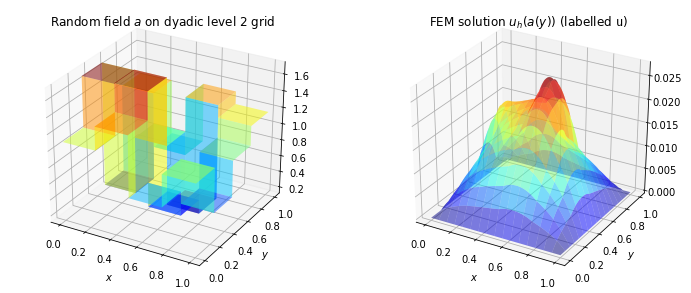

In [1]:
import numpy as np
import scipy as sp
import importlib
import seaborn as sns
import matplotlib.pyplot as plt
import pdb

import sys
sys.path.append("../../")
import pyApproxTools as pat
importlib.reload(pat)

%matplotlib inline

def make_soln(points, fem_div, a_bar=1.0, c=0.5, f=1.0, verbose=False):
    
    solns = []
    fields = []

    for p in points:
        field = pat.PWConstantSqDyadicL2(a_bar + c * p.reshape((side_n, side_n)))
        fields.append(field)
        # Then the fem solver (there a faster way to do this all at once? This will be huge...
        fem_solver = pat.DyadicFEMSolver(div=fem_div, rand_field = field, f = 1)
        fem_solver.solve()
        solns.append(fem_solver.u)
        
    return solns, fields

fem_div = 7

a_bar = 1.0
c = 0.9
field_div = 2
side_n = 2**field_div

np.random.seed(3)
p = 2*np.random.random((1,16)) - 1

u, a = make_soln(p, fem_div=fem_div, a_bar=a_bar, c=c, f=c)
u = u[0]
a = a[0]
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1, projection='3d')
a.plot(ax, title='Random field $a$ on dyadic level 2 grid')
ax = fig.add_subplot(1, 2, 2, projection='3d')
u.plot(ax, title='FEM solution $u_h(a(y))$ (labelled $\mathtt{u}$)')
plt.show()


m = 64


[]

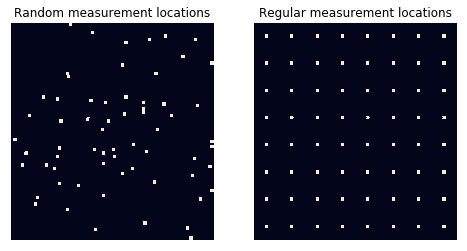

In [2]:
# local_width is the width of the measurement squares in terms of FEM mesh squares
width_div = 1
local_width = 2**width_div
spacing_div = 4

Wm_reg, Wloc_reg = pat.make_local_avg_grid_basis(width_div, spacing_div, fem_div, return_map=True)
Wm_reg = Wm_reg.orthonormalise()

m = Wm_reg.n
print('m =', m)

# We make the ambient spaces for Wm and Vn
np.random.seed(2)

Wm_rand, Wloc = pat.make_pw_local_avg_random_basis(m=m, div=fem_div, width=local_width, return_map=True)
Wm_rand = Wm_rand.orthonormalise()

fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(1, 2, 1)
sns.heatmap(Wloc.values, xticklabels=False, yticklabels=False, cbar=False, ax=ax)
ax.set_title('Random measurement locations')
ax = fig.add_subplot(1, 2, 2)
sns.heatmap(Wloc_reg.values, xticklabels=False, yticklabels=False, cbar=False, ax=ax)
ax.set_title('Regular measurement locations')
plt.plot()

In [13]:
# Make PCA basis
N = int(1e3)
np.random.seed(1)
dict_basis_small, dict_fields = pat.make_pw_reduced_basis(N, field_div, fem_div, a_bar=a_bar, c=c, f=1.0, verbose=False)
dict_basis_small.make_grammian()

cent = dict_basis_small.reconstruct(np.ones(N) / N)

import copy

cent_vecs = copy.deepcopy(dict_basis_small.vecs)
for i in range(len(cent_vecs)):
    cent_vecs[i] = cent_vecs[i] - cent

dict_basis_small_cent = pat.PWBasis(cent_vecs)
dict_basis_small_cent.make_grammian()

lam, V = np.linalg.eigh(dict_basis_small.G)
#PCA_vecs = [cent]
PCA_vecs = []
for i, v in enumerate(np.flip(V.T, axis=0)[:m]):
    vec = dict_basis_small.reconstruct(v)
    PCA_vecs.append(vec / vec.norm())

Vn_PCA = pat.PWBasis(PCA_vecs)

lam, V = np.linalg.eigh(dict_basis_small_cent.G)
#PCA_vecs = [cent]
PCA_vecs_affine = []
for i, v in enumerate(np.flip(V.T, axis=0)[:m]):
    vec = dict_basis_small_cent.reconstruct(v)
    PCA_vecs_affine.append(vec / vec.norm())

Vn_PCA_affine = pat.PWBasis(PCA_vecs_affine)


In [14]:

Vn_PCA.make_grammian()
Vn_PCA.G[1,:]
Vn_PCA_affine.make_grammian()
Vn_PCA_affine.G[1,:]

array([ 1.92554306e-16,  1.00000000e+00, -2.91433544e-16,  2.25514052e-16,
        1.87350135e-16, -1.60461922e-16,  2.14238349e-16,  4.42354486e-16,
        4.16333634e-17,  7.63278329e-17,  1.28369537e-16, -4.16333634e-17,
       -2.58473798e-16, -2.08166817e-17, -2.46330734e-16, -1.30104261e-16,
       -6.85215773e-17, -1.94289029e-16, -2.63677968e-16,  1.63931368e-16,
        2.67147415e-16,  7.07767178e-16,  6.93889390e-18, -4.68375339e-17,
       -4.02455846e-16, -2.08166817e-17, -2.42861287e-16, -3.17454396e-16,
       -1.04083409e-17,  2.20309881e-16,  9.02056208e-17, -1.11022302e-16,
       -5.55111512e-17, -1.11022302e-16, -9.71445147e-17, -1.20736754e-15,
       -1.37910516e-16,  6.07153217e-16,  5.55111512e-17, -6.24500451e-17,
       -5.37764278e-17, -3.67327696e-16,  1.48535698e-16,  5.39282161e-16,
        2.60208521e-16, -4.61002764e-16,  3.78169718e-16, -2.90783023e-16,
        1.10046521e-15, -1.39254927e-15,  1.48405593e-15, -6.11056344e-16,
        1.42681006e-15, -

## $
\bf u^* = \bf \Sigma^{1/2} (\bf G^T \bf \Sigma \bf G)^{-1} (\bf w - \bf G^T \bf \mu) + \bf \mu.
$
## VS
## $ R_{1,1}^{-1} R_{2,1} w $

In [96]:
np.random.seed(1)
N = 40
m = 10
L = 100

# First make a random orthonormal vector
G = sp.stats.ortho_group.rvs(dim=N)
W = G[:, :m] # Our space is only spanned by the first m columns
sigma = np.sort(np.random.random(N))[::-1]
D = np.diag(sigma)
D_sqrt = np.diag(np.sqrt(sigma))
D_inv = np.diag(1.0 / sigma)
wc = 2 * np.random.random(m) - 1
w = W @ wc
u0 = 2 * np.random.random(N) - 1

# Ok - now Albert's reconstruction
T = G.T @ D_inv @ G
w_perp_star = G[:,m:] @ -np.linalg.solve(T[m:,m:], T[m:, :m] @ wc)

if np.allclose(W.T @ w_perp_star, 0):
    print(' * w_perp_star indeed ortho to W')

w_perp_perts = G[:,m:] @ (1e-2 * ((2/np.sqrt(N-m)) * np.random.random((N-m, L)) - 1))

u_star = w + w_perp_star

dist = np.linalg.norm(D @(u_star - u0))
perp_dists = np.linalg.norm(D@(u0 - (u_star + w_perp_perts.T)).T, axis=0)
#print('w', w)
#print('w_perp_star', w_perp_star)
#print('u0', u_star)
#print(w_perp_perts[:,0])
#print(u_star)
print(np.linalg.norm(D@(u0 - (u_star + w_perp_perts[:,55]))))
print(dist)
print(perp_dists - dist)

# Now my way
u_tilde_star = D @ W @ np.linalg.solve(W.T @ D @ W, (wc - W.T @ u0)) + u0

dist = np.linalg.norm(D @(u_tilde_star - u0))
perp_dists = np.linalg.norm(D@(u0 - (u_tilde_star + w_perp_perts.T)).T, axis=0)
print(dist) 
print(perp_dists - dist)


if np.allclose(W.T @ (u_tilde_star - w), 0):
    print(' * (u_tilde_star - u0) indeed ortho to W')                          
                          
if np.allclose(u_star - u_tilde_star, 0):
    print("yep")
else:
    print("nope")
    print(u_star - u_tilde_star)


 * w_perp_star indeed ortho to W
2.6277212609428826
2.6277951973886853
[ 1.79076368e-03  2.42197239e-03  7.19867596e-04  1.29655085e-03
  2.75973044e-03  1.32871362e-03  6.46903482e-04  1.77994947e-03
  1.07928746e-03  1.83409507e-03  2.41493994e-03  1.25253647e-03
  2.34294439e-03  5.62268493e-04  1.32606960e-03  1.16038133e-03
  2.23299314e-03  1.96538630e-03  2.24244642e-03  1.58754409e-03
  1.26991707e-03  1.38546340e-03  7.98383382e-04  1.34635679e-03
  1.66290507e-03  2.18264971e-03  1.89352160e-03  1.03595416e-03
  2.48472347e-03  1.22211561e-03  1.00605758e-03  1.01806752e-03
  1.29001192e-03  3.05926220e-03  1.27791106e-03  2.17389768e-03
  2.51498960e-03  1.03988999e-03  1.16477657e-03  1.40266544e-03
  1.33913658e-03  2.45777843e-03  1.22128407e-03  2.35396079e-03
  2.04743177e-03  2.33012110e-03  2.47116402e-03  3.37419149e-04
  1.45184403e-03  2.56909456e-03  1.38068971e-03  1.67496120e-03
  1.08097775e-03  1.48082189e-03  9.07065549e-04 -7.39364458e-05
  2.10091401e-03  1

In [54]:
print(u_star)
print(u_tilde_star)

[-9.33343512e-02  1.21697875e-01 -7.32942995e-02  5.18753642e-01
  2.60750899e-02 -1.45668360e-01 -8.94424010e-01 -1.58385525e-01
 -2.44251943e-01  6.67051872e-01  2.31323159e-01  2.58279693e-01
 -5.64099554e-01 -8.05239099e-01 -4.64757181e-01  8.30541171e-02
 -2.88477062e-01  5.38501413e-01 -4.03456594e-01  5.76520130e-01
  2.56054187e-01 -1.53009499e-01 -1.84629353e-01  3.84788903e-01
 -2.54339117e-01  7.10219571e-02 -1.96313456e-01 -4.40382162e-02
 -6.40053426e-03  3.34242770e-02 -3.96215666e-02 -1.22769912e-01
 -1.56267447e-02  4.04051369e-02 -1.26232018e-02 -2.35951821e-02
  2.43613566e-02 -3.36337166e-02  6.58924890e-05  1.01924870e-02]
[-0.12378272 -0.17036865 -0.34070793  0.95221389  0.28044387  0.54209986
  0.04867159 -0.47877666  0.05188487  0.98858488  0.38239551 -0.28453959
 -0.93682735 -0.00848141  0.32547718  0.69224596 -0.91359577  0.68966119
 -0.36378868  0.92338763 -0.468112   -0.5880075   0.49323228  0.35428095
 -0.83188919  0.54038885 -1.18743958 -0.34861109  0.91511